In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sktime.datasets import make_causal_pricing
from sktime.forecasting.causal import DoubleMLForecaster
from sktime.forecasting.compose import (
    OosForecaster,
    make_reduction,
)
from sktime.split import ExpandingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series

## Data

### Loading the dataset

In [2]:
n_series = 100
n_timepoints = 100
n_categories_d = 45
n_categories_k = 15
random_state = 43

np.random.seed(random_state)

X, y, ground_truth = make_causal_pricing(
    n_series=n_series,
    n_timepoints=n_timepoints,
    n_categories_d=n_categories_d,
    n_categories_k=n_categories_k,
    random_state=random_state,
    return_ground_truth=True,
)

print("Shapes:", X.shape, y.shape)

Shapes: (10000, 7) (10000, 1)


In [3]:
X.head()

discount        stock  week_number   d   k  promotion  \
article_id time                                                          
0          0          0.0  1819.252954            0  20  13          1   
           1          0.0  1806.637343            1  20  13          1   
           2          0.0  1801.112150            2  20  13          1   
           3          0.0  1798.298406            3  20  13          1   
           4          0.1  1798.298406            4  20  13          1   

                        p0  
article_id time             
0          0     29.936962  
           1     29.936962  
           2     29.936962  
           3     29.936962  
           4     29.936962

In [4]:
y.head()

demand
article_id time           
0          0     12.615611
           1      5.525194
           2      2.813744
           3      0.000000
           4      2.868626

### Exploring Ground Truth

In [5]:
ground_truth.keys()

dict_keys(['treatment_effects', 'base_demand', 'causal_dag', 'metadata'])

In [6]:
ground_truth["treatment_effects"].head()

article_id
0   -4.516135
1   -1.020031
2   -4.289721
3   -4.100257
4   -3.618782
Name: treatment_effect, dtype: float64

In [7]:
ground_truth["base_demand"].head()

base_demand
article_id time             
0          0      147.814988
           1      140.724570
           2      138.013121
           3      125.879200
           4      124.548066

In [8]:
ground_truth["metadata"]

{'n_series': 100,
 'n_timepoints': 100,
 'n_categories_d': 45,
 'n_categories_k': 15,
 'reference': 'Schultz et al. (2024), arXiv:2312.15282',
 'random_state': 43,
 'causal_structure': 'q_it = q^b_it + p_it * e_i',
 'treatment_variable': 'price',
 'outcome_variable': 'demand',
 'heterogeneous_effects': True}

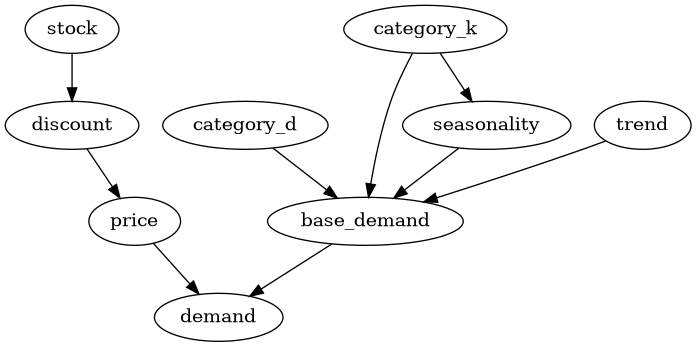

In [9]:
G = ground_truth["causal_dag"]

viz = G.to_graphviz()
viz.draw("causal_forecasting.png", prog="dot")
Image("causal_forecasting.png")

## Exploratory Data Analysis

### 1. Quick Sanity Checks
Check ranges, missing values, and distribution shapes.


Describing X
           discount         stock   week_number             d             k  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.223790   3673.749649     49.500000     22.810000      7.120000   
std        0.202882   3869.125154     28.867513     13.651833      4.191343   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000    528.868143     24.750000     11.000000      4.000000   
50%        0.200000   2291.854594     49.500000     23.500000      7.000000   
75%        0.400000   5876.061711     74.250000     35.000000     10.250000   
max        0.500000  19971.913529     99.000000     44.000000     14.000000   

          promotion            p0  
count  10000.000000  10000.000000  
mean       0.270000     37.984248  
std        0.443982     35.880087  
min        0.000000      0.537426  
25%        0.000000     15.639242  
50%        0.000000     30.011023  
75%        1.000000    

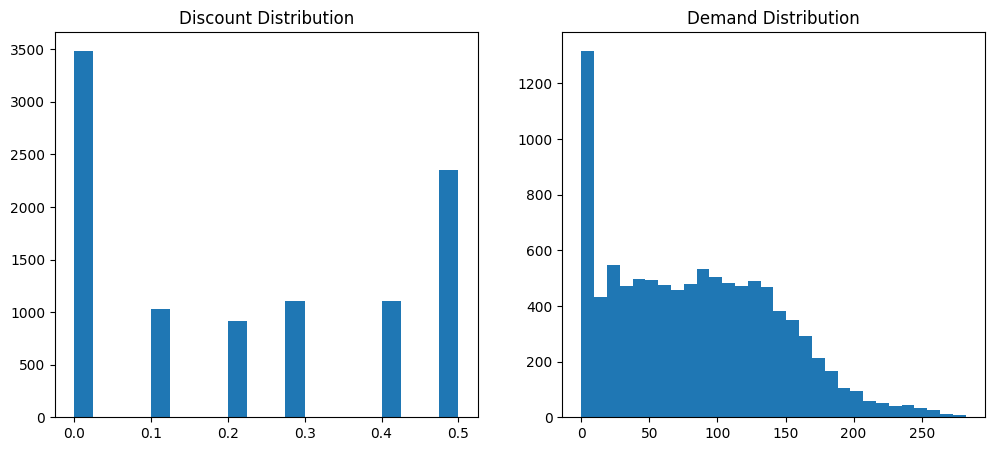

In [10]:
print("Describing X")
print(X.describe())
print("\nDescribing y")
print(y.describe())

# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X["discount"], bins=20)
plt.title("Discount Distribution")

plt.subplot(1, 2, 2)
plt.hist(y["demand"], bins=30)
plt.title("Demand Distribution")
plt.show()

### 2. Select 5 Random Articles (Fixed for whole notebook)

In [11]:
unique_ids = X.index.get_level_values("article_id").unique()
size = 5

if len(unique_ids) <= size:
    sample_ids = unique_ids.values
else:
    sample_ids = np.random.choice(unique_ids, size=5, replace=False)

sample_ids

array([20,  2, 15, 22, 57])

### 3. Demand Over Time for Selected Articles

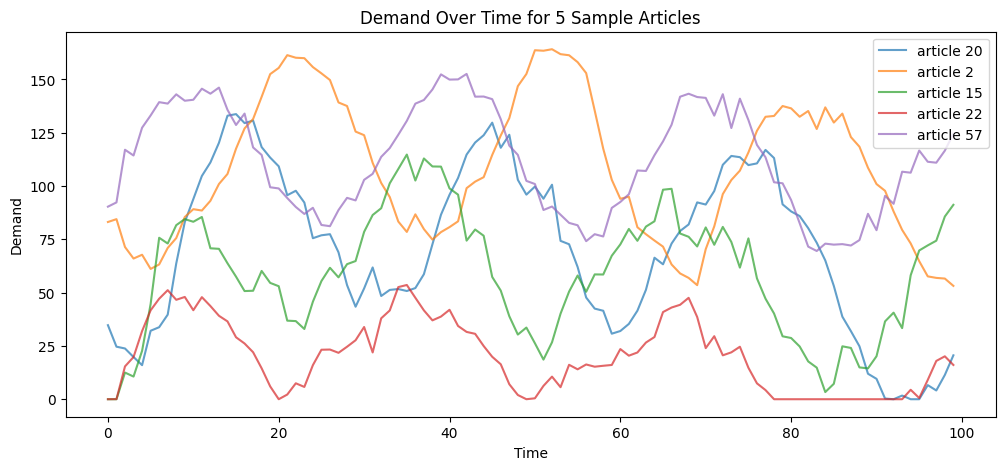

In [12]:
plt.figure(figsize=(12, 5))
for i in sample_ids:
    series = y.loc[i]["demand"]
    plt.plot(series.index, series.values, label=f"article {i}", alpha=0.7)

plt.title("Demand Over Time for 5 Sample Articles")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()

### 4. Stock / Discount / Demand Evolution for a Single Article
This helps visualize the pricing policy reacting to stock.


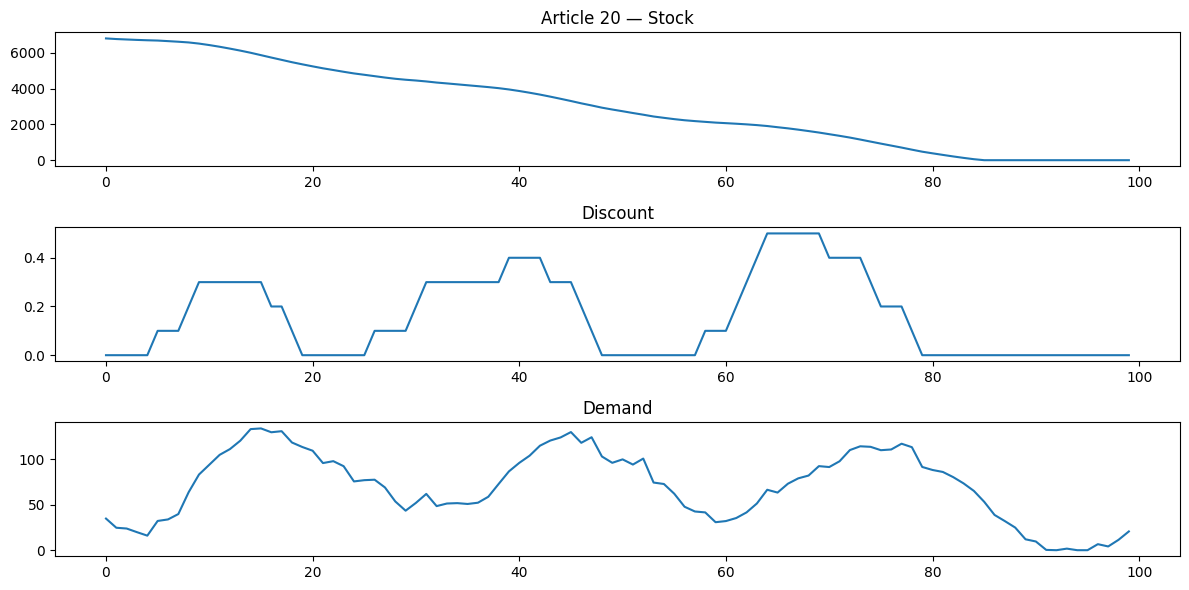

In [13]:
chosen = sample_ids[0]
sub = X.loc[chosen].join(y.loc[chosen])

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(sub.index, sub["stock"])
plt.title(f"Article {chosen} — Stock")

plt.subplot(3, 1, 2)
plt.plot(sub.index, sub["discount"])
plt.title("Discount")

plt.subplot(3, 1, 3)
plt.plot(sub.index, sub["demand"])
plt.title("Demand")
plt.tight_layout()
plt.show()

### 5. Discount → Demand Relationship
For articles pooled (dense, but confirms negative slope).

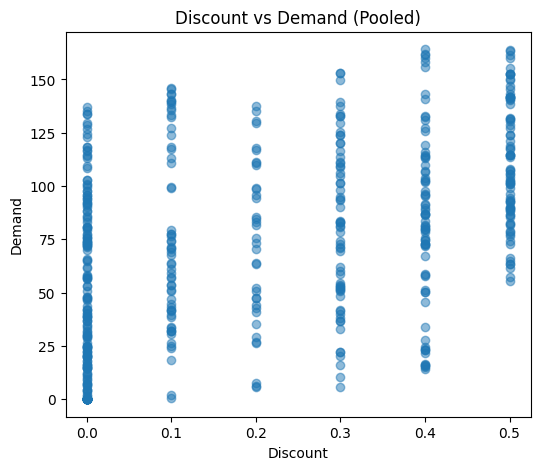

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(X.loc[sample_ids]["discount"], y["demand"].loc[sample_ids], alpha=0.5)
plt.xlabel("Discount")
plt.ylabel("Demand")
plt.title("Discount vs Demand (Pooled)")
plt.show()

### 6. Category Effects on Demand (Brand `d` and Group `k`)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


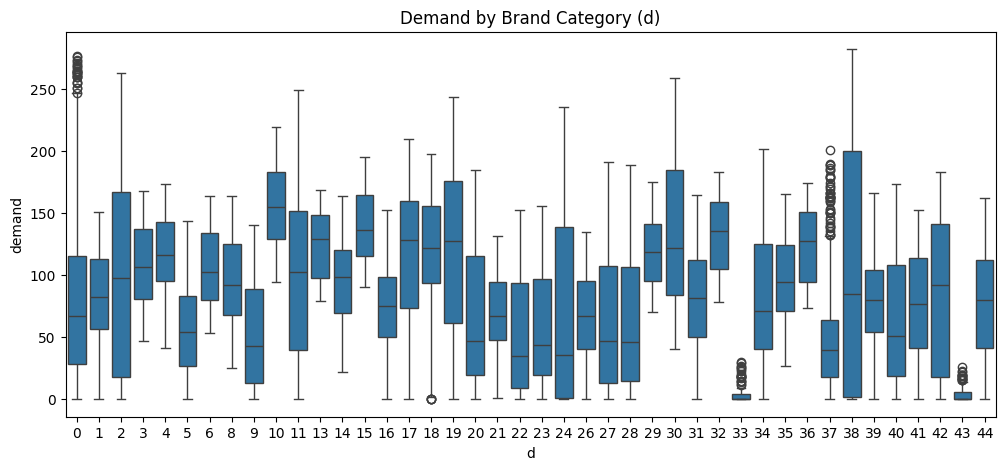

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


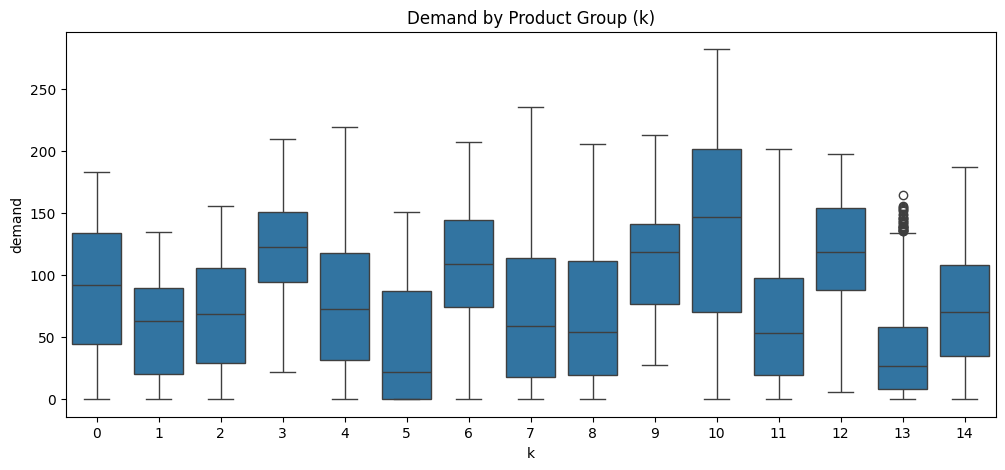

In [15]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=X["d"], y=y["demand"])
plt.title("Demand by Brand Category (d)")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=X["k"], y=y["demand"])
plt.title("Demand by Product Group (k)")
plt.show()

### 7. Seasonality Check - Average Demand by Week Number


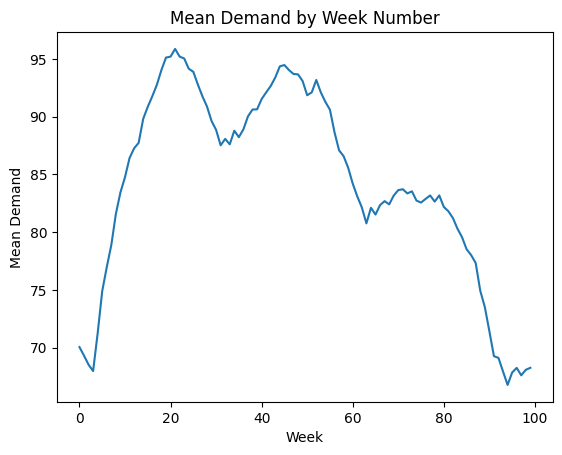

In [16]:
mean_by_week = y["demand"].groupby(X["week_number"]).mean()
plt.plot(mean_by_week.index, mean_by_week.values)
plt.title("Mean Demand by Week Number")
plt.xlabel("Week")
plt.ylabel("Mean Demand")
plt.show()

# Forecasting

In [17]:
def plot_samples(y_train, y_test, preds, sample_ids=None, width=14, height=4):
    """Plot time series samples with predictions."""
    if sample_ids is None:
        sample_ids = y_train.index.get_level_values("article_id").unique()

    for aid in sample_ids:
        fig, ax = plt.subplots(figsize=(width, height))

        plot_series(
            y_train.loc[aid],
            y_test.loc[aid],
            preds.loc[aid],
            labels=["Train", "Test", "Prediction"],
            ax=ax,
        )

        ax.set_title(f"Article ID: {aid}", fontsize=14, pad=10)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

        plt.tight_layout()
        plt.show()

In [18]:
test_size = 0.2
fh = list(range(1, int(test_size * n_timepoints) + 1))

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size)

In [19]:
window_length = 30

forecaster = make_reduction(
    RandomForestRegressor(
        n_estimators=10,
        max_depth=2,
        # criterion="absolute_error",
        random_state=random_state,
    ),
    window_length=window_length,
)

forecaster = OosForecaster(
    forecaster,
    ExpandingWindowSplitter(initial_window=window_length + 1),
    strategy="refit",
    backend="loky",
)

outcome_fcst = clone(forecaster)
treatment_fcst = clone(forecaster)
residual_fcst = clone(forecaster)

Forecasting without exogenous data

Mean Squared Error: 512.5727


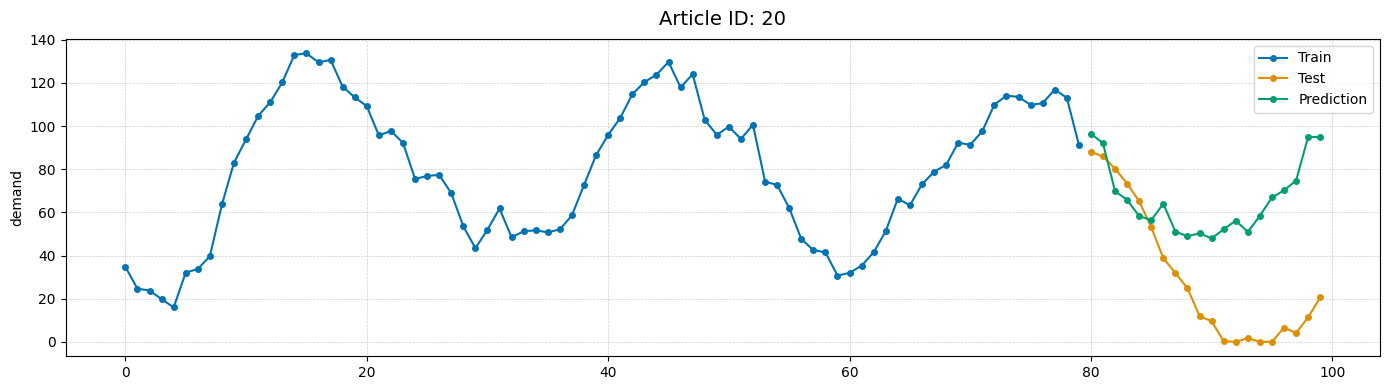

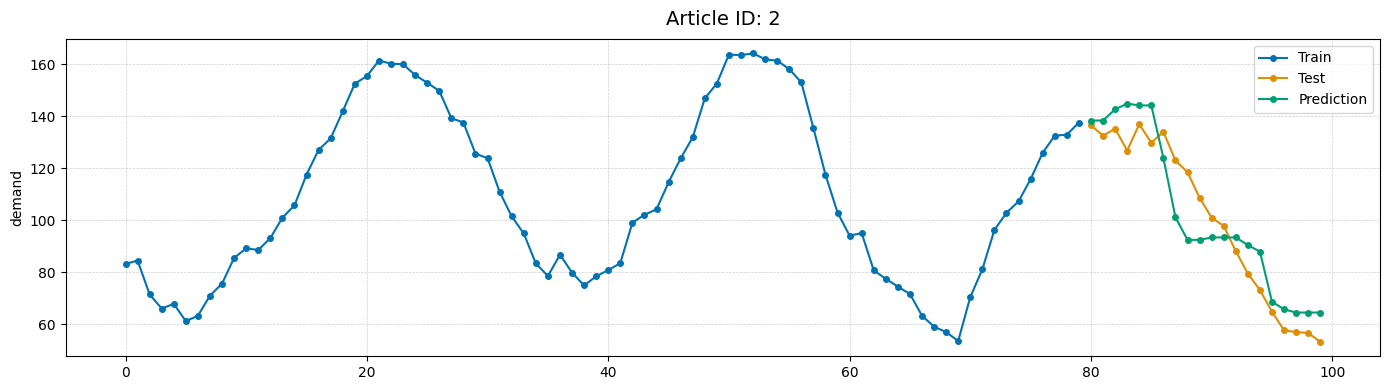

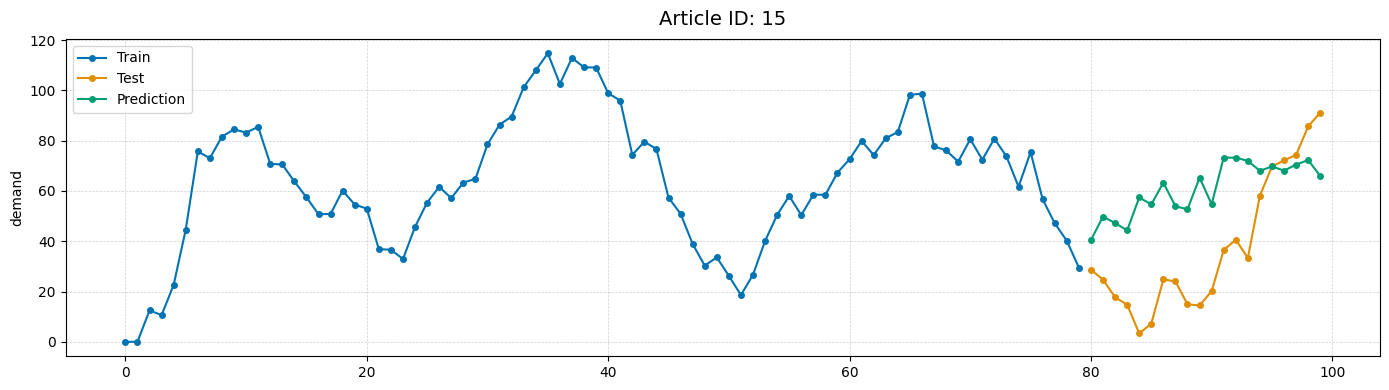

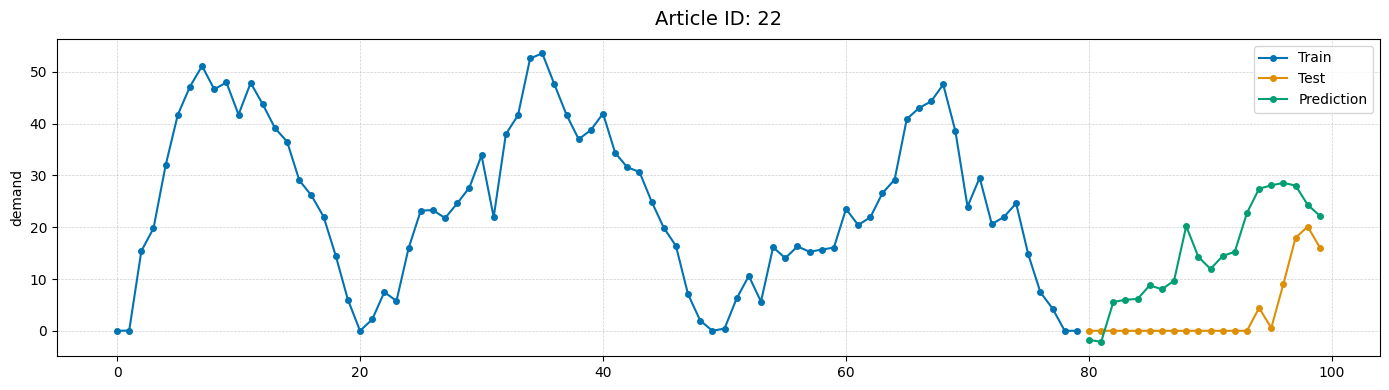

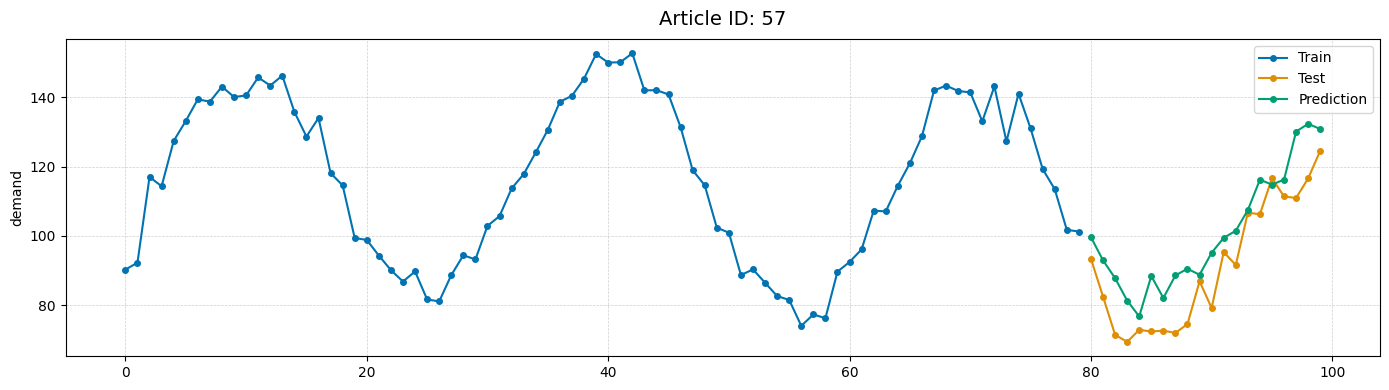

In [20]:
dml_forecaster = DoubleMLForecaster(
    outcome_fcst=outcome_fcst,
    treatment_fcst=treatment_fcst,
    residual_fcst=residual_fcst,
    starting_window=window_length + 1,
)

dml_forecaster.fit(y=y_train, fh=fh)
preds = dml_forecaster.predict()
preds = preds.loc[y_test.index]
mae = mean_squared_error(y_test, preds)

print(f"Mean Squared Error: {mae:.4f}")
plot_samples(y_train, y_test, preds, sample_ids=sample_ids)

Forecasting with exogenous data and price as treatment

Mean Squared Error: 478.9052


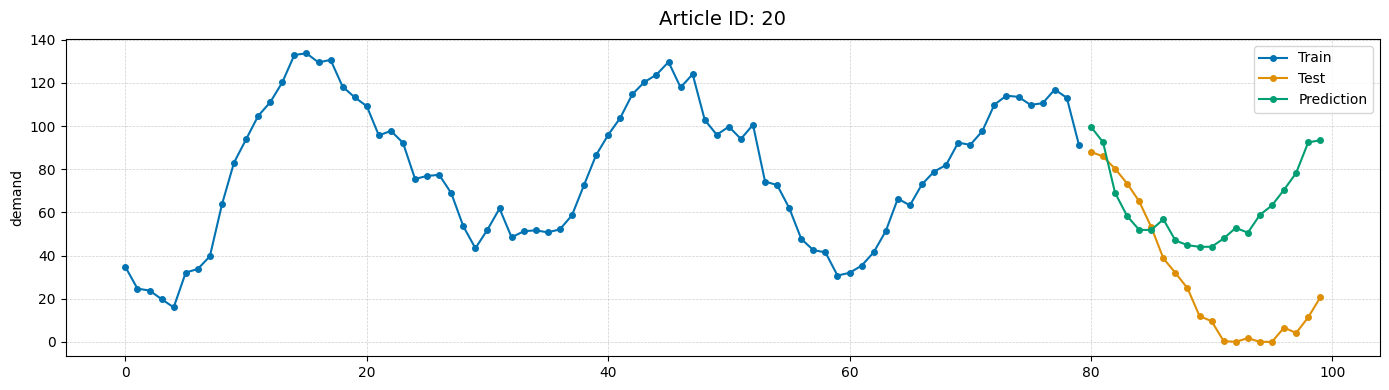

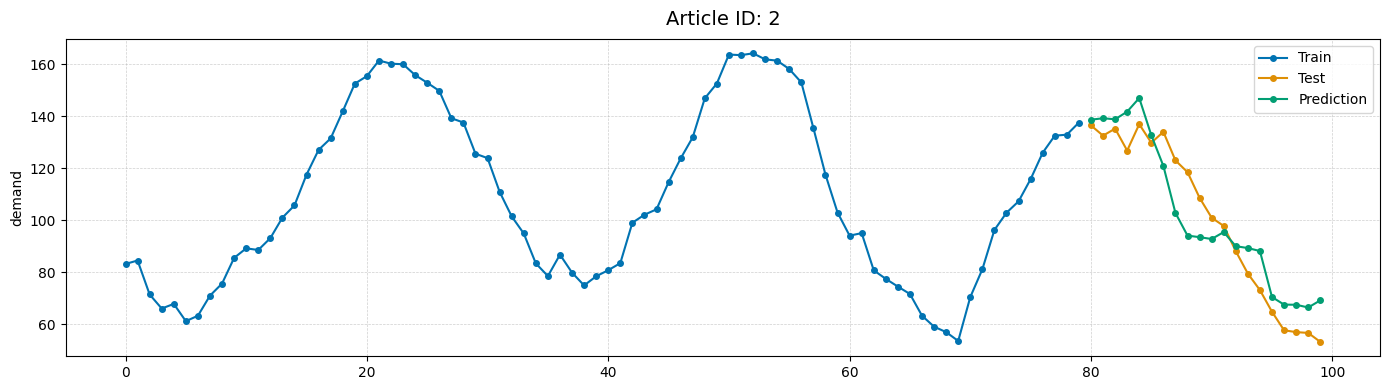

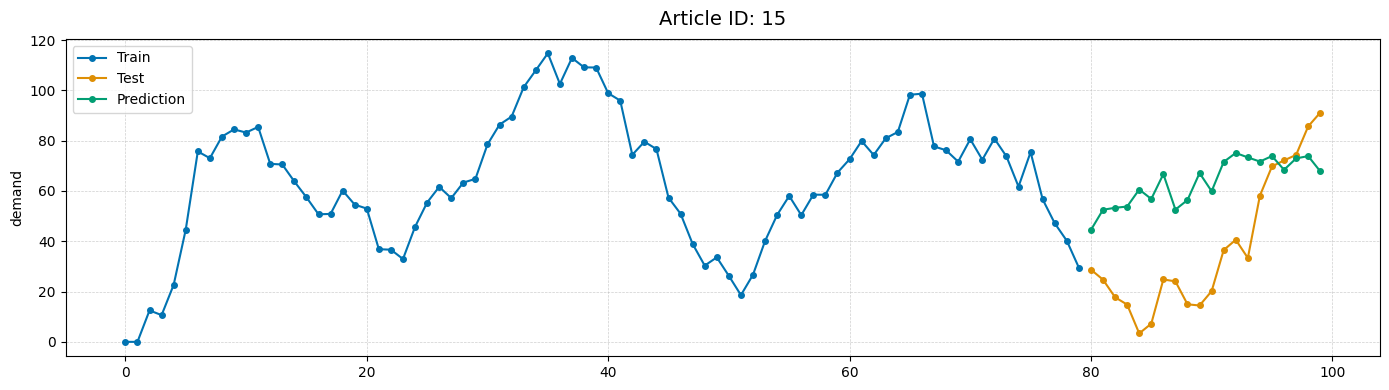

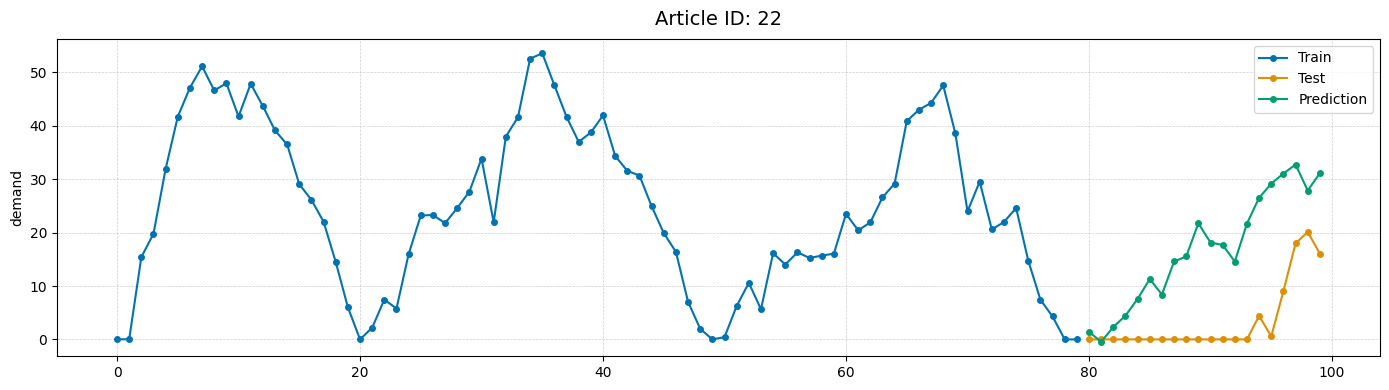

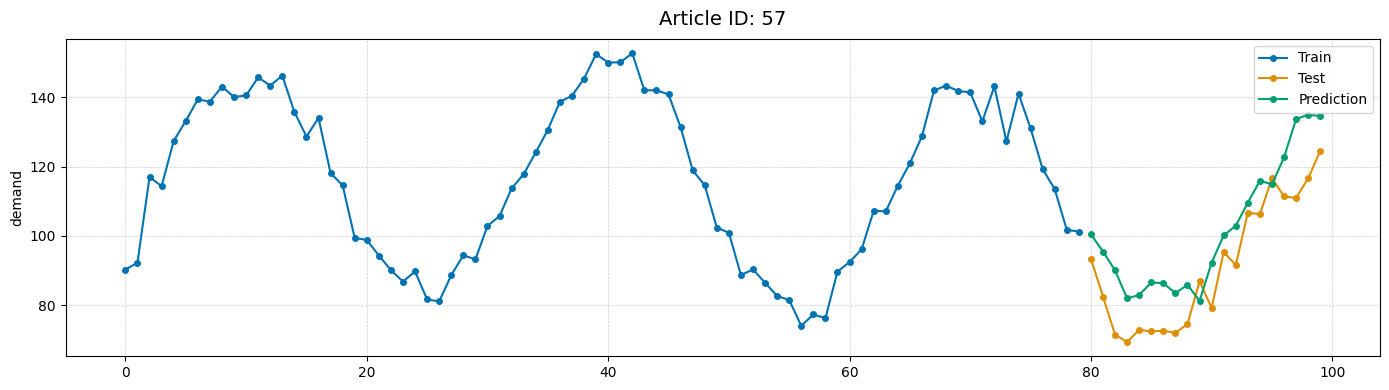

In [21]:
dml_forecaster = DoubleMLForecaster(
    outcome_fcst=outcome_fcst,
    treatment_fcst=treatment_fcst,
    residual_fcst=residual_fcst,
    starting_window=window_length + 1,
    exposure_vars=["p0"],
)

dml_forecaster.fit(y=y_train, X=X_train, fh=fh)
preds = dml_forecaster.predict(X=X_test)
preds = preds.loc[y_test.index]
mae = mean_squared_error(y_test, preds)

print(f"Mean Squared Error: {mae:.4f}")
plot_samples(y_train, y_test, preds, sample_ids=sample_ids)